# Fetching crypto and tweets data.

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from crypto_api import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)

# Analysis of tweets

In [46]:
'''
TODO: GENERAL DATA TASKS:
0) find a way to deal with multiple tweets for a day
1) merge 2 datasets into 
2) imput missing data, maybe try interpolation or expectation maximization
    2.1) compare with mean, median imput methods
3) ivestigate relationship within data, maybe correlation matrix etc
'''

tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
# tweets_df['date'] = pd.to_datetime(tweets_df['date'])

# btc_df = pd.read_csv('Data/btc_data.csv')
# btc_df['time'] = pd.to_datetime(btc_df['time'])

# tweets_df = tweets_df[tweets_df['date'].dt.date.isin(btc_df['time'].dt.date)]
                                               
# tweets_df = (tweets_df
#              .dropna(axis=1, how='all')
#              .drop(['vibe','cashtags'], axis=1)) # 1 and 18 notna values respectively  

## Dealing with sparse columns

In [3]:
sparse_cols = tweets_df.columns[tweets_df.notnull().mean() < 1.0].values.copy()

mod_tweets_df = tweets_df.copy()
mod_tweets_df = (mod_tweets_df[mod_tweets_df['lang']=='en']
                 .drop(['id','url','source','sourceUrl'], axis=1)                 
                 .reset_index(drop=True)
                 .copy())

mod_tweets_df = mod_tweets_df.drop(['lang'], axis=1)

## Data cleaning and preprocessing

In [4]:
encoder = OrdinalEncoder()
mod_tweets_df['sourceLabel_encoded'] = encoder.fit_transform(mod_tweets_df['sourceLabel'].values.reshape(-1, 1))
mod_tweets_df['isReplied']   = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['inReplyToUser']]
mod_tweets_df['isMentioned'] = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['mentionedUsers']]

#mod_tweets_df = mod_tweets_df.drop(['sourceLabel','inReplyToUser','mentionedUsers'], axis=1)


def extract_dict(line: str, prepare_to_df: False):
    """Extracts data from a dict represented as string and makes it a dict.

    ## Parameters:
        line (str): row of a Series/DataFrame to be preprocessed.
        prepare_to_df (bool): prepares extracted dict to be wrapped into DataFrame.

    ## Returns:
        dict: extracted dict from string.
    """    

    extracted_content = dict(re.findall(r"'(\w+)': '?({.*}|datetime.datetime\(.*\)|[\w\d/:\. ]*)'?", line))
    
    # Wraps dict values into lists to be easily represented as a DataFrame row.
    if prepare_to_df:
        for key,value in extracted_content.items():
            if value == '':
                extracted_content[key] = [None]
            else:
                extracted_content[key] = value
        
    return extracted_content


new_df = mod_tweets_df.copy()     
extracted_df = (pd.DataFrame([*mod_tweets_df['user']
                              .apply(lambda x: extract_dict(x, True))])
                )

new_df = (pd.concat([new_df, extracted_df], axis=1)
            .drop(['user','username','id','displayname','verified','created',
                    'location','protected','profileImageUrl','profileBannerUrl',
                    'rawDescription','renderedDescription','favouritesCount',
                    'friendsCount','mediaCount','statusesCount'], axis=1))

In [5]:
# Converting columns containing numbers to int after extraction.
for column in new_df:
    if 'Count' in column:
        new_df[column] = new_df[column].astype('Int64').copy()

In [6]:
new_df[['rawContent','isReplied','isMentioned']].query("rawContent.str.contains('@')")

new_df['mentionsCount'] = new_df['rawContent'].str.count(r'@[\w\d]+')
new_df['mentions'] = new_df['rawContent'].apply(lambda x : re.findall(r'(@[^\s]+)', x))

count = 0
for a,b in new_df[['mentionsCount','mentions']].values:
    if a==len(b):
        count +=1 
print(count==len(new_df))

new_df['charCount'] = new_df['rawContent'].apply(lambda x: len(x))
new_df = new_df.drop('descriptionLinks', axis=1)

True


In [7]:
#links = tweets_df[tweets_df.columns[tweets_df.columns.isin(new_df.columns)==False]]['links'].value_counts().copy()

tweets_df[tweets_df['rawContent']=='True']['quotedTweet'].iloc[0]

'{\'url\': \'https://twitter.com/ggreenwald/status/1625871270737809408\', \'date\': datetime.datetime(2023, 2, 15, 14, 54, 52, tzinfo=datetime.timezone.utc), \'rawContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'renderedContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'id\': 1625871270737809408, \'user\': {\'username\': \'ggreenwald\', \'id\': 16076032, \'displayname\': \'Glenn Greenwald\', \'rawDescription\': \'Journalist; Author; Host, @SystemUpdate_; Columnist, @Folha; Co-Founder: The Intercept, @TheInterceptBr; @abrigo_hope, @FreedomofPress, @ongcriadefavela.

In [8]:
import re
import json
import datetime


def clean_text(raw_text):    
    cleaned_text = re.sub(r' \'?(displayname|renderedDescription)\'?: (.*?)(\'|None),', '', raw_text)
    cleaned_text = (cleaned_text
                    .replace("'",'"')
                    .replace('None','null')
                    .replace('True','true')
                    .replace('False','false'))
    # cleaned_text = re.sub(r'(\w+)"(\w+)', r"\1'\2", cleaned_text)
    
    return cleaned_text


def deserialize(text):    
    deserialized_texts = []
    extract_dicts = re.findall(r'{.*?}',text)
    
    for str_dict in extract_dicts:
        cleaned_text = clean_text(str_dict)

        pattern = r'datetime.datetime\(.*\)'
        cleaned_text = re.sub(f'({pattern})',r'"\1"',cleaned_text)
        
        deserialized_text = json.loads(cleaned_text)
        
        if deserialized_text['created']!=None:
            deserialized_text['created'] = eval(deserialized_text['created'])
        
        deserialized_texts.append(deserialized_text)

    return deserialized_texts
    
    
new_df = new_df.drop('inReplyToUser',axis=1)
new_df['mentionedUsers'] = new_df['mentionedUsers'].apply(lambda x: deserialize(x) if type(x)==str else None)

In [9]:
# new_df['sourceLabel'] encode this 1,2,3
new_df = new_df.drop(['links','media','link'], axis=1)

for item in tweets_df.columns:
    print(f"{item:<18} {item in new_df['quotedTweet'][new_df['quotedTweet'].notna()].iloc[0]}")

url                True
date               True
rawContent         True
renderedContent    True
id                 True
user               True
replyCount         True
retweetCount       True
likeCount          True
quoteCount         True
conversationId     True
lang               True
source             True
sourceUrl          True
sourceLabel        True
links              True
media              True
retweetedTweet     True
quotedTweet        True
inReplyToTweetId   True
inReplyToUser      True
mentionedUsers     True
coordinates        True
place              True
hashtags           True
cashtags           True
card               True
viewCount          True
vibe               True


In [10]:
object_cols = [col for col in new_df if new_df[col].dtype==object]
print(object_cols)

# new_df['hashtags'][new_df['hashtags'].notna()]

['rawContent', 'renderedContent', 'sourceLabel', 'quotedTweet', 'mentionedUsers', 'hashtags', 'cashtags', 'card', 'vibe', 'label', 'mentions']


In [11]:
new_df[new_df['quotedTweet'].notna() & new_df['card'].notna()].iloc[0,]

date                                           2019-05-04 23:05:47+00:00
rawContent             Order online in 2 mins, 7 day return policy ht...
renderedContent        Order online in 2 mins, 7 day return policy Te...
replyCount                                                           777
retweetCount                                                        1780
likeCount                                                          22999
quoteCount                                                           177
conversationId                                       1124812395300343808
sourceLabel                                           Twitter for iPhone
retweetedTweet                                                       NaN
quotedTweet            {'url': 'https://twitter.com/cleantechnica/sta...
inReplyToTweetId                                                     NaN
mentionedUsers                                                      None
coordinates                                        

In [12]:
tweets_df['quotedTweet'][tweets_df['quotedTweet'].notna()].iloc[0]

'{\'url\': \'https://twitter.com/SpaceX/status/614551591601844224\', \'date\': datetime.datetime(2015, 6, 26, 21, 51, 31, tzinfo=datetime.timezone.utc), \'rawContent\': \'Rocket completed hold down firing today in advance of Sunday cargo mission to @Space_Station http://t.co/tdni53IviI http://t.co/PjiYSIDTOu\', \'renderedContent\': \'Rocket completed hold down firing today in advance of Sunday cargo mission to @Space_Station spacex.com/webcast http://t.co/PjiYSIDTOu\', \'id\': 614551591601844224, \'user\': {\'username\': \'SpaceX\', \'id\': 34743251, \'displayname\': \'SpaceX\', \'rawDescription\': \'SpaceX designs, manufactures and launches the world’s most advanced rockets and spacecraft\', \'renderedDescription\': \'SpaceX designs, manufactures and launches the world’s most advanced rockets and spacecraft\', \'descriptionLinks\': None, \'verified\': True, \'created\': datetime.datetime(2009, 4, 23, 21, 53, 30, tzinfo=datetime.timezone.utc), \'followersCount\': 28768901, \'friendsCou

In [13]:
# ok fuck it, let's fuse something from new_df to crypto data

btc_df = pd.read_csv('Data/btc_data.csv')
btc_df['time'] = pd.to_datetime(btc_df['time'])

tweets_df[tweets_df['date'].dt.date.isin(btc_df['time'].dt.date)]

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
2932,https://twitter.com/elonmusk/status/9308768459...,2017-11-15 19:15:09+00:00,"Sorry, date is tomorrow night at 8pm. This pic...","Sorry, date is tomorrow night at 8pm. This pic...",930876845959946240,"{'username': 'elonmusk', 'id': 44196397, 'disp...",683,695,12536,65,...,9.308757e+17,"{'username': 'elonmusk', 'id': 44196397, 'disp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2933,https://twitter.com/elonmusk/status/9308757393...,2017-11-15 19:10:45+00:00,"It can transform into a robot, fight aliens an...","It can transform into a robot, fight aliens an...",930875739397791744,"{'username': 'elonmusk', 'id': 44196397, 'disp...",1935,12438,64591,1542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2934,https://twitter.com/elonmusk/status/9306817600...,2017-11-15 06:19:57+00:00,@rjcc @Tesla Do you really believe that someon...,@rjcc @Tesla Do you really believe that someon...,930681760026853377,"{'username': 'elonmusk', 'id': 44196397, 'disp...",136,62,854,19,...,9.306783e+17,"{'username': 'rjcc', 'id': 15009761, 'displayn...","[{'username': 'rjcc', 'id': 15009761, 'display...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2935,https://twitter.com/elonmusk/status/9306776291...,2017-11-15 06:03:32+00:00,@rjcc @Tesla That is a *counterpoint* to illus...,@rjcc @Tesla That is a *counterpoint* to illus...,930677629161758726,"{'username': 'elonmusk', 'id': 44196397, 'disp...",36,27,711,5,...,9.306759e+17,"{'username': 'rjcc', 'id': 15009761, 'displayn...","[{'username': 'rjcc', 'id': 15009761, 'display...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936,https://twitter.com/elonmusk/status/9314120200...,2017-11-17 06:41:45+00:00,Tesla Semi https://t.co/7VLz7F46Ji,Tesla Semi https://t.co/7VLz7F46Ji,931412020016029696,"{'username': 'elonmusk', 'id': 44196397, 'disp...",1879,20114,103777,2398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21770,https://twitter.com/elonmusk/status/1644862856...,2023-04-09 00:40:39+00:00,@teslaownersSV Got to break a few eggs to make...,@teslaownersSV Got to break a few eggs to make...,1644862856448339969,"{'username': 'elonmusk', 'id': 44196397, 'disp...",4826,4900,113346,391,...,1.644817e+18,"{'username': 'teslaownersSV', 'id': 1016059981...","[{'username': 'teslaownersSV', 'id': 101605998...",NaN,NaN,NaN,NaN,NaN,5883818.0,NaN
21771,https://twitter.com/elonmusk/status/1644861079...,2023-04-09 00:33:35+00:00,@Jason @DeanPreston @GrowSF Good question,@Jason @DeanPreston @GrowSF Good question,1644861079107895298,"{'username': 'elonmusk', 'id': 44196397, 'disp...",166,179,2663,14,...,1.644820e+18,"{'username': 'Jason', 'id': 3840, 'displayname...","[{'username': 'Jason', 'id': 3840, 'displaynam...",NaN,NaN,NaN,NaN,NaN,518864.0,NaN
21772,https://twitter.com/elonmusk/status/1644860793...,2023-04-09 00:32:27+00:00,"Friendship takes work, enmity is effortless","Friendship takes work, enmity is effortless",1644860793224085506,"{'username': 'elonmusk', 'id': 44196397, 'disp...",8821,20876,145759,1571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15961060.0,NaN
21773,https://twitter.com/elonmusk/status/1644857727...,2023-04-09 00:20:16+00:00,@BillyM2k 🤣,@BillyM2k 🤣,1644857727166955523,"{'username': 'elonmusk', 'id': 44196397, 'disp...",261,231,4476,14,...,1.644818e+18,"{'username': 'BillyM2k', 'id': 30699048, 'disp...","[{'username': 'BillyM2k', 'id': 30699048, 'dis...",NaN,NaN,NaN,NaN,NaN,656404.0,NaN


# NLP Model Bulding

## Preprocessing and vectorizing

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, matutils, utils, models
import spacy


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    url_pattern = [{"label": "URL",
                    "pattern": [{"LIKE_URL": True}]}]

    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(url_pattern)
    
    texts_out = []
    if type(texts)!=list:
        texts = [texts]
    
    for text in texts:
        # TODO: consider using nlp.pipe which should be faster
        doc = nlp(text)
        cleaned_text = []
        for token in doc:
            if token.ent_type_ != 'URL' and not token.is_stop and token.pos_ in allowed_postags:
                cleaned_text.append(token.lemma_)
        final = ' '.join(cleaned_text)
        texts_out.append(final)

    return texts_out


def create_ngrams(texts):
    data_words = []
    for text in texts:
        new = utils.simple_preprocess(text)
        data_words.append(new)

    bigrams_phrases  = models.Phrases(data_words, min_count=3, threshold=50)
    trigrams_phrases = models.Phrases(bigrams_phrases[data_words], threshold=50)

    bigram  = models.phrases.Phraser(bigrams_phrases)
    trigram = models.phrases.Phraser(trigrams_phrases)

    data_bigrams = [bigram[doc] for doc in data_words]
    data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]
    
    return data_bigrams_trigrams


def vectorize_texts(texts_ngrams):
    id2word = corpora.Dictionary(texts_ngrams)
    corpus = [id2word.doc2bow(text) for text in texts_ngrams]
    return id2word, corpus


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def make_custom_pipeline(steps):
    for i, step in enumerate(steps):
        steps.insert(i, (step[0], FunctionTransformer(step[1])))
        steps.remove(step)

    return Pipeline(steps)


# with open('lemmatized_texts.txt', 'r', encoding="utf-8") as f:
#     lemmatized_texts = f.readlines()
    
# lemmatized_texts = [line.replace('\n','') for line in lemmatized_texts]

# lemmatized_texts = lemmatization(new_df['rawContent'])
steps = [('lemmatization', lemmatization),
         ('trigrams', create_ngrams),
         ('vectorization', vectorize_texts)]

preprocessing_pipeline = make_custom_pipeline(steps)
id2word, corpus = preprocessing_pipeline.transform(new_df['rawContent'].values.tolist())

# data_bigrams_trigrams = create_ngrams(lemmatized_texts)
# id2word, corpus = vectorize_texts(data_bigrams_trigrams)

#tfidf = models.TfidfModel(corpus, id2word=id2word)
# tfidf_vectorizer = TfidfVectorizer(max_df=0.6,
#                                    min_df=5,
#                                    ngram_range=(1,3))
# tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_texts)

# id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
# corpus = matutils.Sparse2Corpus(tfidf_matrix.T)

In [16]:
# low_value = 0.03
# words = []
# words_missing_in_tfidf = []

# for i in range(0, len(corpus)):
#     bow = corpus[i]
#     low_value_words = []
#     tfidf_ids = [id for id,_ in tfidf[bow]]
#     bow_idf = [id for id,_ in bow]
#     low_value_words = [id for id, value in tfidf[bow] if value < low_value]
#     drops = low_value_words+words_missing_in_tfidf
    
#     for item in drops:
#         words.append(id2word[item])
    
#     # words with tfidf score of 0 will be missing
#     words_missing_in_tfidf = [id for id in bow_idf if id not in tfidf_ids]
#     new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
#     corpus[i] = new_bow

In [17]:
from gensim.models import CoherenceModel


def bayesian_tuning(model, params_grid: dict, texts, verbose=False):
    # TODO: implement bayesian tuning
    models_scores = {}
    for i in range(95,170,5):
        lda_model = model(corpus=params_grid['corpus'],
                          num_topics=i,
                          id2word=params_grid['id2word'],
                          random_state=1,
                          passes=10,
                          per_word_topics=True)
        
        coherence_model_lda = CoherenceModel(model=lda_model, 
                                             texts=texts, 
                                             corpus=params_grid['corpus'], 
                                             dictionary=params_grid['id2word']
                                             )
        coherence_score = coherence_model_lda.get_coherence()
        
        models_scores.update({lda_model: coherence_score})
        
        if verbose:
            print(f'Topics {i:<3}: {coherence_score}')
    
    return models_scores


params_grid = {'corpus':corpus,  
               'num_topics':10, 
               'id2word':id2word, 
               'random_state':1, 
               'update_every':1, 
               'chunksize':3000, 
               'passes':2}

# lda_models_scores = bayesian_tuning(LdaMulticore, params_grid, texts, verbose=True)

In [18]:
import pyLDAvis.gensim_models as gensimvis
from gensim.models import LdaMulticore
import pyLDAvis


pyLDAvis.enable_notebook()

lda_model = LdaMulticore(corpus=corpus,
                         num_topics=15,
                         id2word=id2word,
                         random_state=1,
                         passes=10,
                         per_word_topics=True)

vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.016266  0.084225       1        1  9.089922
7      0.099300 -0.017544       2        1  8.904330
4      0.086446 -0.035073       3        1  7.359555
14     0.116861 -0.011278       4        1  7.350949
11     0.146678 -0.042532       5        1  6.920620
0      0.011084  0.049703       6        1  6.804254
1      0.020613  0.075573       7        1  6.683292
8     -0.013359  0.036610       8        1  6.667996
5     -0.107831  0.013398       9        1  6.587339
2     -0.025585  0.041853      10        1  6.235742
10    -0.027976 -0.001489      11        1  5.976652
3     -0.064917  0.013167      12        1  5.714617
13    -0.079290 -0.215485      13        1  5.393800
6     -0.109360  0.094117      14        1  5.235818
12    -0.068930 -0.085247      15        1  5.075112, topic_info=         Term        Freq       Total Category  logprob  loglift
29       true  347.000000  347.000000  Default  30.0000  30.0000
999   exactly  391.000000  391.000000  Default  29.0000  29.0000
699     thank  191.000000  191.000000  Default  28.0000  28.0000
263      look  258.000000  258.000000  Default  27.0000  27.0000
8        work  584.000000  584.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
9232   billym   22.633153  445.106086  Topic15  -5.4548   0.0019
697       big   19.815576  231.126689  Topic15  -5.5878   0.5243
200     right   17.537726  318.686749  Topic15  -5.7099   0.0810
6        need   17.667484  546.229517  Topic15  -5.7025  -0.4505
763       use   17.142900  199.233572  Topic15  -5.7327   0.5279

[1142 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
9639       9  0.926237        abide
611        3  0.925260        abort
186        1  0.021087   absolutely
186        6  0.920794   absolutely
186        7  0.007029   absolutely
...      ...       ...          ...
639       14  0.039259    yesterday
5282       1  0.794095        yield
11355      5  0.864410  zaleskiluke
10753      4  0.950651    zerohedge
10885      8  0.903232    zubymusic

[4039 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 5, 15, 12, 1, 2, 9, 6, 3, 11, 4, 14, 7, 13])

In [19]:
def prepare_new_texts(texts: list[str]):
    steps = [('lemmatization', lemmatization),
            ('trigrams', create_ngrams)]

    corpus_pipeline = make_custom_pipeline(steps)
    texts_ngrams = corpus_pipeline.transform(texts)
    corpus = [id2word.doc2bow(text) for text in texts_ngrams]
    
    return corpus

In [20]:
# corpus = [id2word.doc2bow(text) for text in texts_ngrams]
# lda_model.get_document_topics(corpus, minimum_probability=0)

In [21]:
new_df['vectorized']  = preprocessing_pipeline.transform(new_df['rawContent'].values.tolist())[1]
new_df['TopicsProbs'] = new_df['vectorized'].apply(lambda x: dict(lda_model.get_document_topics(x, minimum_probability=0)))

In [23]:
# datesCount = new_df.groupby(new_df['date'].dt.date)['date'].count()
# new_df = new_df.merge(datesCount.rename('tweetsCount'), left_on=new_df['date'].dt.date, right_index=True, how='left')

In [24]:
# plot_this = new_df.groupby(new_df['date'].dt.date).count()['date']
# plot_this

In [2]:
tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)

btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
btc_df = btc_df.rename(columns={'time':'date'})
btc_df['date'] = pd.to_datetime(btc_df['date']).dt.date

# meow = pd.concat([new_df, pd.DataFrame(new_df['TopicsProbs'].tolist())], axis=1).copy()

tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date
#btc_df['date'] = pd.to_datetime(btc_df['date'])

In [3]:
merged_pieces = pd.merge(btc_df, tweets_df, on='date', how='inner')
numeric_cols_names = merged_pieces.columns[merged_pieces.dtypes!=object][1:]
merged_pieces = merged_pieces[numeric_cols_names].dropna(axis=1)

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


train, test  = train_test_split(merged_pieces, train_size=0.8)
labels_train = train['close'].values
labels_test  = test['close'].values

dtrain = xgb.DMatrix(train.drop('close',axis=1), label=labels_train)
dtest  = xgb.DMatrix(test.drop('close',axis=1), label=labels_test)

param = {'max_depth': 20, 'objective': 'reg:squarederror'}
param['nthread'] = 2
param['eval_metric'] = 'mape'
#param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train'), (dtest, 'test')]

num_round = 30
bst = xgb.train(param, dtrain, num_round, evals=evallist)

[0]	train-mape:0.70008	test-mape:0.70019
[1]	train-mape:0.49013	test-mape:0.49020
[2]	train-mape:0.34310	test-mape:0.34318
[3]	train-mape:0.24022	test-mape:0.24023
[4]	train-mape:0.16822	test-mape:0.16828
[5]	train-mape:0.11789	test-mape:0.11787
[6]	train-mape:0.08271	test-mape:0.08270
[7]	train-mape:0.05811	test-mape:0.05814
[8]	train-mape:0.04092	test-mape:0.04094
[9]	train-mape:0.02888	test-mape:0.02894
[10]	train-mape:0.02044	test-mape:0.02056
[11]	train-mape:0.01450	test-mape:0.01466
[12]	train-mape:0.01031	test-mape:0.01052
[13]	train-mape:0.00734	test-mape:0.00758
[14]	train-mape:0.00524	test-mape:0.00551
[15]	train-mape:0.00374	test-mape:0.00403
[16]	train-mape:0.00268	test-mape:0.00299
[17]	train-mape:0.00192	test-mape:0.00225
[18]	train-mape:0.00138	test-mape:0.00172
[19]	train-mape:0.00100	test-mape:0.00135
[20]	train-mape:0.00072	test-mape:0.00109
[21]	train-mape:0.00053	test-mape:0.00090
[22]	train-mape:0.00038	test-mape:0.00077
[23]	train-mape:0.00028	test-mape:0.00067
[2

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

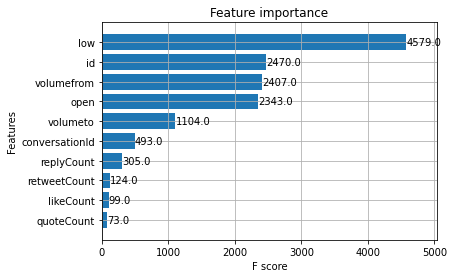

In [33]:
xgb.plot_importance(bst, height=0.8, grid=1)